In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.linalg
from uncertainties import ufloat, correlated_values
from uncertainties import unumpy as unp
from glob import glob
from tqdm import tqdm
from copy import copy
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import uncertainties
import statsmodels.stats.correlation_tools
from uncertainties import covariance_matrix

In [3]:
from ROOT import gSystem
gSystem.Load('libanalysis.so')
from ROOT import Belle2
Belle2.Variable.Manager.Instance()

Welcome to JupyROOT 6.24/00


In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [5]:
pd.options.display.float_format = '{:.2f}'.format

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [6]:
#from analysis_vcb.selection import sig_id_to_label
from academy.analysis.plotting import init_plot_style, add_watermark, channel_label
from academy.analysis.settings import *
from academy.analysis.constants import *

init_plot_style()

In [7]:
df_mc = pd.read_hdf('AcademySample.h5')

In [8]:
plotoutdir = "output/Unfolding"
try:
    os.makedirs(plotoutdir)
except FileExistsError:
    pass

In [9]:
channels = [
    15,  #S B0 -> D*+ e nu
    16,  #S B0 -> D*+ mu nu
    #17,  #+ B+ -> D*0 e nu
    #18,  #+ B+ -> D*0 mu nu
]

channels_Dstar = [
    #21,  #+ D*0 -> D0 pi0
    23,  #S D*+ -> D0 pi+
    24,  #S D*+ -> D+ pi0
]  
channels_D = [
    31,  #S D+ -> K- pi+ pi+
    32,  #N D+ -> K- pi+ pi+ pi0
    33,  #N D+ -> K- pi+ pi+ pi+ pi-
    34,  #N D+ -> Ks pi+
    35,  #N D+ -> Ks pi+ pi0
    36,  #N D+ -> Ks pi+ pi+ pi-
    37,  #N D+ -> Ks K^+
    38,  #N D+ -> K+ K- pi^+
    41,  #S D0 -> K- pi+
    42,  #S D0 -> K- pi+ pi0
    43,  #S D0 -> K- pi+ pi+ pi-
    44,  #N D0 -> K- pi+ pi+ pi- pi0
    45,  #N D0 -> Ks pi0
    46,  #N D0 -> Ks pi+ pi-
    47,  #N D0 -> Ks pi+ pi- pi0
    48,  #N D0 -> K+ K+
]

## Setup

In [10]:
fit_variable = "m2RecoilSignalSide_after_smearing" 
fit_variable_label = r"$M_\mathrm{miss}^2$"
fit_variable_unit = r"GeV$^2$/$c^4$"
fit_bins = np.array([-1.0, -0.25, 0.25, 0.75, 1.25, 2.0])
fit_range = (min(fit_bins), max(fit_bins))
fit_vois = ["wReco", "costhetalReco"]

In [11]:
df_mc = df_mc.query(f"{fit_range[0]} < {fit_variable} < {fit_range[1]}")

In [12]:
markers = {
    15: "v",
    16: "s",   
}

In [13]:
data_type="data"

In [14]:
plotoutdir = os.path.join(plotoutdir, data_type)
try:
    os.makedirs(plotoutdir)
except FileExistsError:
    pass
print(plotoutdir)

output/Unfolding/data


In [15]:
yields = pd.read_pickle(os.path.join(f"output/Fitting/data", "yields.pkl"))

In [16]:
correlations = {}
for channel in channels:
    correlations[channel] = statsmodels.stats.correlation_tools.corr_nearest(  # Fix negative eigenvalues
        pd.read_pickle(os.path.join(f"output/Fitting/{data_type}", f"correlation_{channel}.pkl")).values,
        threshold=2e-7
    )

In [17]:
covariances = {}
for channel in channels:
    covariances[channel] = np.outer(
        unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$']), 
        unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$'])
    ) * correlations[channel]

/tmp/ipykernel_19167/3844272123.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$']),
/tmp/ipykernel_19167/3844272123.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$'])


In [18]:
results = {}
for channel in channels:
    results[channel] = correlated_values(
        unp.nominal_values(yields.loc[channel_label[channel], '$\nu_\mathrm{sig}$']),
        covariances[channel]
    )

/tmp/ipykernel_19167/1806168015.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  unp.nominal_values(yields.loc[channel_label[channel], '$\nu_\mathrm{sig}$']),


## Theory

In [19]:
from academy.formfactors.BGL import BToDStarBGL
from academy.rates.BtoV import BtoV

In [20]:
theory_bin_boundaries = {}
theory_expectation = {}
full_theory_bgl = {}

In [21]:
param_central_values = np.array(
        [
            1.00e-3,  # a0
            -2.35e-3,  # a1
            0.511e-3,  # b0
            0.67e-03,  # b1
            3.0e-04,  # c1
            -3.68e-03,  # c2
        ]
    )  # type: np.array

In [22]:
m_Bzero = 5.27963
m_Dstarplus = 2.01026

vcb_cln = 37.4e-3
vcb_bgl = 41.6558e-3

In [23]:
btodst_bgl_ff = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = param_central_values[0:2],
    exp_coeff_b = param_central_values[2:4],
    exp_coeff_c = param_central_values[4:6],
)

btodst_bgl = BtoV(btodst_bgl_ff, Vcb=vcb_cln)

In [24]:
theory_bin_boundaries["mixed"] = {}
for voi in fit_vois:
    bin_edges = copy(bin_edges_all[voi])
    if voi == "wReco":
        bin_edges[0]  = btodst_bgl_ff.kinematics.w_range_numerical_stable[0]
        bin_edges[-1] = btodst_bgl_ff.kinematics.w_range_numerical_stable[1]
        
    integration_boundaries = []
    for bin_boundaries in zip(bin_edges, bin_edges[1:]):
        integration_boundaries.append(bin_boundaries)
    theory_bin_boundaries["mixed"][voi] = integration_boundaries

In [25]:
# Reweight total rate, because Vcb is in the rate calculation but we want the BR in the MC
total_rate_theory_bgl_weight = (BR_B0_to_Dstplus_lepton.nominal_value / tauBzero) / btodst_bgl.Gamma()

In [26]:
theory_expectation["mixed"] = {}
theory_expectation["mixed"]["BGL"] = {}
theory_expectation["mixed"]["BGL"]["wReco"] = np.array([btodst_bgl.DGamma_Dw(l, u) / (u - l) for l, u in theory_bin_boundaries["mixed"]["wReco"]])
theory_expectation["mixed"]["BGL"]["costhetalReco"] = np.array([btodst_bgl.DGamma_DcosL(l, u) / (u - l) for l, u in theory_bin_boundaries["mixed"]["costhetalReco"]])

In [27]:
for channel in channels:
    full_theory_bgl[channel] = {}
    full_theory_bgl[channel] = np.array([theory_expectation["mixed"]["BGL"][voi] for voi in fit_vois]).flatten() * total_rate_theory_bgl_weight

In [28]:
full_theory_bgl

{15: array([2.41605702e-14, 4.10189524e-14, 4.86572993e-14, 5.22436756e-14,
        5.31455727e-14, 5.20494131e-14, 4.93820035e-14, 4.54406339e-14,
        4.04468790e-14, 3.43457819e-14, 4.46712266e-15, 7.01741857e-15,
        9.16272977e-15, 1.09030563e-14, 1.22383981e-14, 1.31687551e-14,
        1.36941275e-14, 1.38145152e-14, 1.35299182e-14, 1.28403364e-14]),
 16: array([2.41605702e-14, 4.10189524e-14, 4.86572993e-14, 5.22436756e-14,
        5.31455727e-14, 5.20494131e-14, 4.93820035e-14, 4.54406339e-14,
        4.04468790e-14, 3.43457819e-14, 4.46712266e-15, 7.01741857e-15,
        9.16272977e-15, 1.09030563e-14, 1.22383981e-14, 1.31687551e-14,
        1.36941275e-14, 1.38145152e-14, 1.35299182e-14, 1.28403364e-14])}

# Acceptance

In [29]:
linestyles = {
    15: "-",
    16: "--",
}

acceptance_corrections = {}
acceptance_corrections_integrated = {}

In [30]:
bin_widths = {}
foo = []
for voi in fit_vois:
    foo.append([x[1] - x[0] for x in theory_bin_boundaries["mixed"][voi]])
bin_widths["mixed"] = np.array(foo).flatten()
del foo

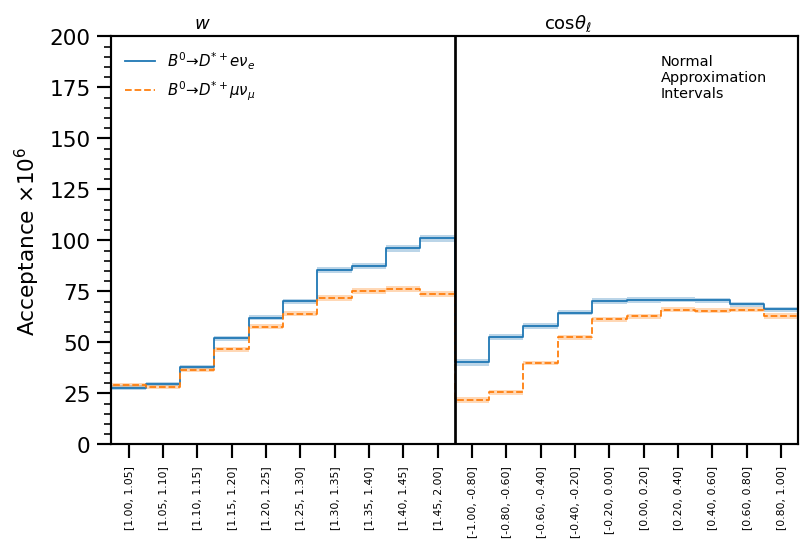

In [31]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for channel in channels:

    histogram = []
    histogram_unc = []
    for voi in fit_vois:
        bin_edges = copy(bin_edges_all[voi])
        query = f"SIG_ID in (4.1, 4.2) and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel} and {fit_range[0]} < {fit_variable} < {fit_range[1]}"

        hist, _ = np.histogram(
            df_mc.query(query)[voi_mc[voi]],
            bins=bin_edges, 
            density=False,
            weights=df_mc.query(query)["__weight_overall__"],
           )
        histogram.append(hist)
        hist_unc, _ = np.histogram(
            df_mc.query(query)[voi_mc[voi]],
            bins=bin_edges, 
            density=False,
            weights=df_mc.query(query)["__weight_overall__"] ** 2,
           )
        histogram_unc.append(hist_unc)
        
    signal_mc_histogram = np.array(histogram).flatten()
    signal_mc_histogram_unc = np.array(histogram_unc).flatten()
    

    expected = unp.nominal_values(full_theory_bgl[channel] * 2 * N_BB.nominal_value * BR_GENERIC_MIXED.nominal_value * tauBzero * bin_widths["mixed"])
    
    acceptance_corrections[channel] = unp.uarray(
            signal_mc_histogram,
            signal_mc_histogram_unc ** 0.5
    ) / expected[:20]
    acceptance = unp.nominal_values(acceptance_corrections[channel])
    acceptance_unc = unp.std_devs(acceptance_corrections[channel])
    ax.step(range(-1,21), 1e6*np.array([acceptance[0], *acceptance, acceptance[-1]]), ls=linestyles[channel], where="mid", label=channel_label[channel], lw=1)
    ax.bar(
        range(0, 20),
        height=1e6 * 2 * acceptance_unc,
        bottom=1e6 * (acceptance - acceptance_unc),
        width=1, alpha=0.3,
    )

tmp = {}
for voi in fit_vois:
    tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
tmp = np.array([b for voi in fit_vois for b in tmp[voi]])

# We want to show all ticks...
ax.set_xticks(np.arange(len(tmp)))
# ... and label them with the respective list entries
ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlim(-0.5, 19.5)
ax.set_ylim(0, 200)
ax.axvline(9.5, color="black")

ax.text(0.8, 0.85, "Normal\nApproximation\nIntervals", fontsize=8, transform=ax.transAxes)
ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
ax.text(0.55+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)

ax.set_ylabel(r"Acceptance $\times 10^6$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.savefig(f"{plotoutdir}/acceptance.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/acceptance.png", transparent=True)   
plt.show()
plt.close()

In [32]:
def make_plot_pretty(ax, bin_edges_all):
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlim(-0.5, 19.5)

    ax.axvline(9.5, color="black")

    ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
    ax.text(0.55+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)
    
    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
    return ax

# Unfolding

In [34]:
from academy.analysis.unfolding import extract_bs_spectrum, determine_migration_martrix

In [35]:
def determine_migration_martrix_N(df, bin_edges, col_mc, col_reco, weight_column="__weight_overall__"):
    df.loc[:, f"bins_{col_mc}"] = pd.cut(df[col_mc], bins=bin_edges, labels=range(len(bin_edges)-1))
    df.loc[:, f"bins_{col_reco}"] = pd.cut(df[col_reco], bins=bin_edges, labels=range(len(bin_edges)-1))
    
    return np.array([
        np.array([
            sum(df.query(f"bins_{col_reco} == {i_reco_bin} and bins_{col_mc} == {i_mc_bin}")[weight_column])
            for i_reco_bin in range(len(bin_edges)-1)
        ]) #/ sum(df.query(f"bins_{col_mc} == {i_mc_bin}")[weight_column])
        for i_mc_bin in range(len(bin_edges)-1)
    ]).transpose()


migration_matrices_N = {}

for channel in channels:
    migration_matrices_N[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        migration_matrices_N[channel][voi] = determine_migration_martrix_N(df_mc.query(query), bin_edges_all[voi], voi_mc[voi], voi)
        
full_migrations_N = {}

for channel in channels:
    n_bins = len(fit_vois)*10
    full_migration = np.zeros((n_bins, n_bins))
    for i, voi in enumerate(fit_vois):
        full_migration[i*10:(i+1)*10, i*10:(i+1)*10] = migration_matrices_N[channel][voi]
    full_migrations_N[channel] = full_migration

In [36]:
migration_matrices = {}

for channel in channels:
    migration_matrices[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        migration_matrices[channel][voi] = determine_migration_martrix(df_mc.query(query), bin_edges_all[voi], voi_mc[voi], voi)

In [37]:
full_migrations = {}

for channel in channels:
    n_bins = len(fit_vois)*10
    full_migration = np.zeros((n_bins, n_bins))
    for i, voi in enumerate(fit_vois):
        full_migration[i*10:(i+1)*10, i*10:(i+1)*10] = migration_matrices[channel][voi]
    full_migrations[channel] = full_migration

In [38]:
mc_distributions = {}

for channel in channels:
    mc_distributions[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        mc_distributions[channel][voi] = np.histogram(df_mc.query(query)[voi_mc[voi]], bins=bin_edges_all[voi], weights=df_mc.query(query)["__weight_overall__"])[0]
        
        
mc_reco_distributions = {}

for channel in channels:
    mc_reco_distributions[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        mc_reco_distributions[channel][voi] = np.histogram(df_mc.query(query)[voi], bins=bin_edges_all[voi], weights=df_mc.query(query)["__weight_overall__"])[0]

In [39]:
full_mc_distributions = {}

for channel in channels:
    full_mc_distributions[channel] = np.concatenate(tuple(mc_distributions[channel][voi] for voi in fit_vois))
    
full_mc_reco_distributions = {}

for channel in channels:
    full_mc_reco_distributions[channel] = np.concatenate(tuple(mc_reco_distributions[channel][voi] for voi in fit_vois))

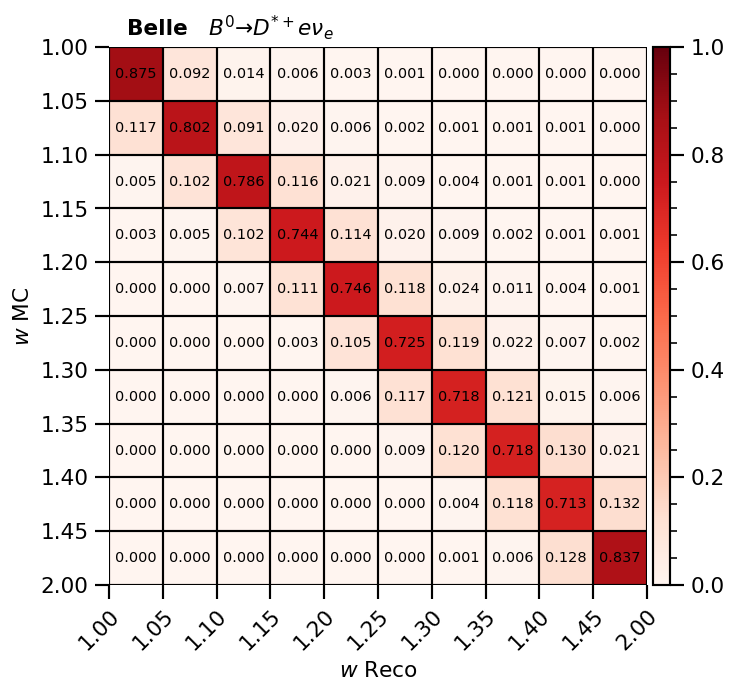

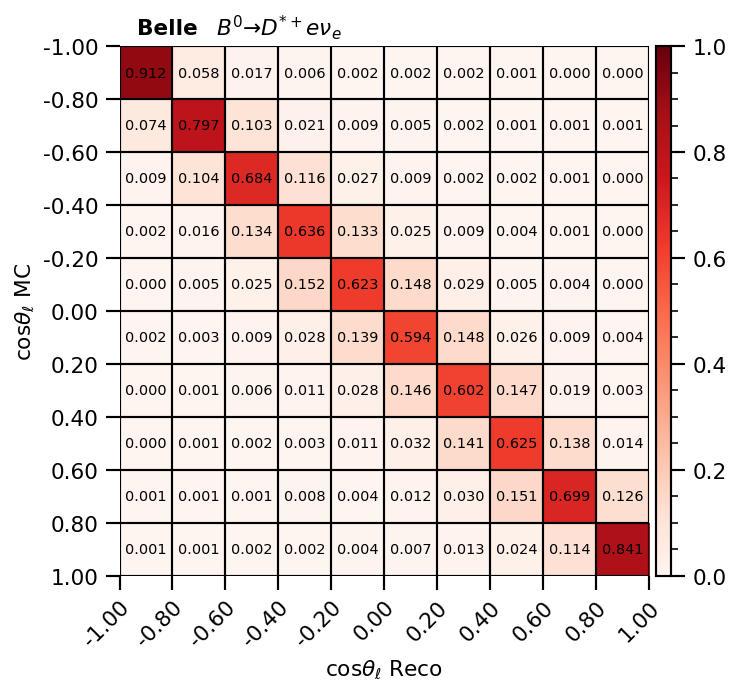

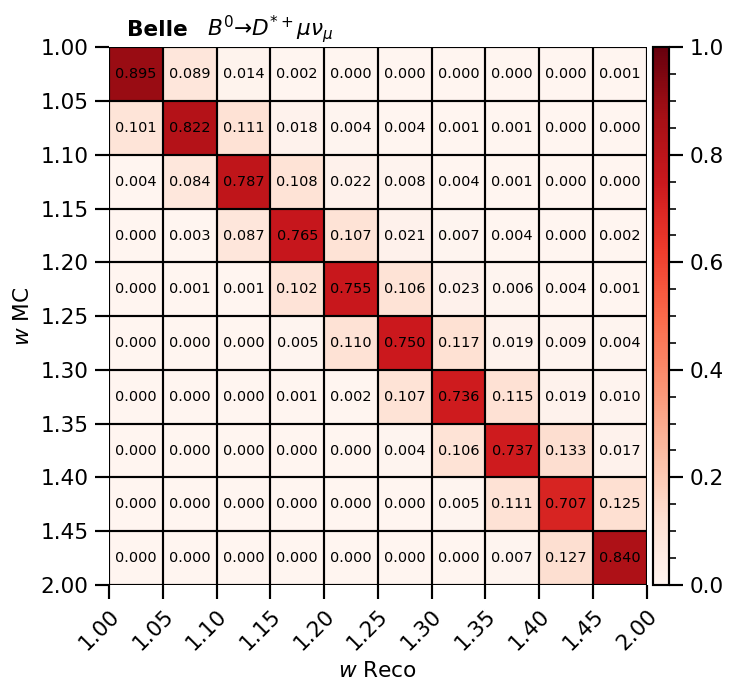

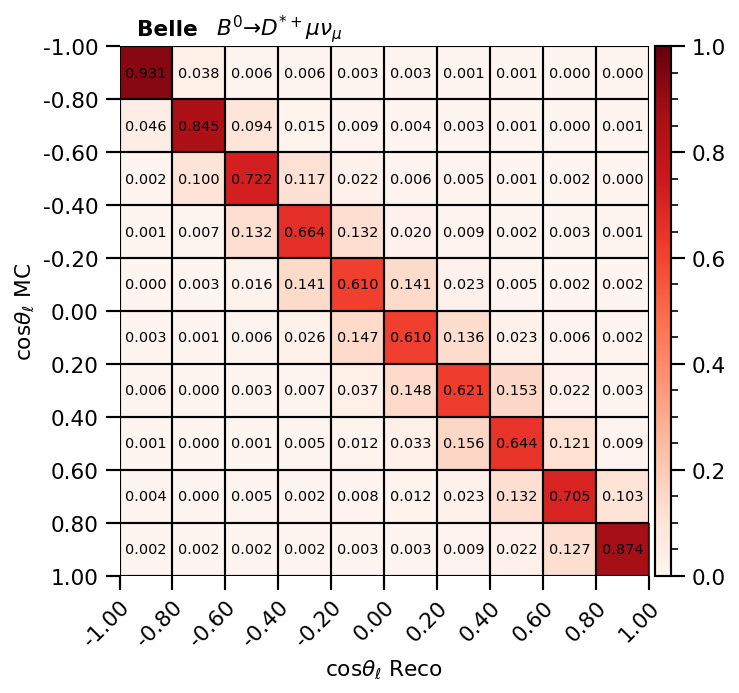

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for channel in channels:
    for voi in fit_vois:
        migration_matrix = migration_matrices[channel][voi]
        fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4 / 0.8))
        im = ax.imshow(migration_matrix, vmin=0, vmax=1, cmap=plt.get_cmap("Reds"))

        # We want to show all ticks...
        bin_edges = bin_edges_all[voi]
        ax.set_xticks(np.arange(len(bin_edges)) - 0.5)
        ax.set_yticks(np.arange(len(bin_edges)) - 0.5)
        # ... and label them with the respective list entries
        ax.set_xticklabels([f"{x:.2f}" for x in bin_edges])
        ax.set_yticklabels([f"{x:.2f}" for x in bin_edges])

        ax.set_xlabel(f"{voi_labels[voi]} Reco")
        ax.set_ylabel(f"{voi_labels[voi]} MC")

        # Create colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
        #cbar.ax.set_ylabel("...", rotation=-90, va="center")

        # Turn spines off and create white grid.
        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        ax.set_xticks(np.arange(migration_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(migration_matrix.shape[0]+1)-.5, minor=True)
        ax.grid(which="major", color="black", linestyle='-', linewidth=1.2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(len(bin_edges)-1):
            for j in range(len(bin_edges)-1):
                text = ax.text(j, i, f"{migration_matrix[i, j]:.3f}",
                               ha="center", va="center", color="black", fontsize=8)


        add_watermark(ax, channel_label[channel])
        plt.tight_layout()
        plt.savefig(f"{plotoutdir}/migration_matrix_channel{channel}_{voi}.pdf", transparent=True)
        plt.savefig(f"{plotoutdir}/migration_matrix_channel{channel}_{voi}.png", transparent=True) 
        plt.show()
        plt.close()

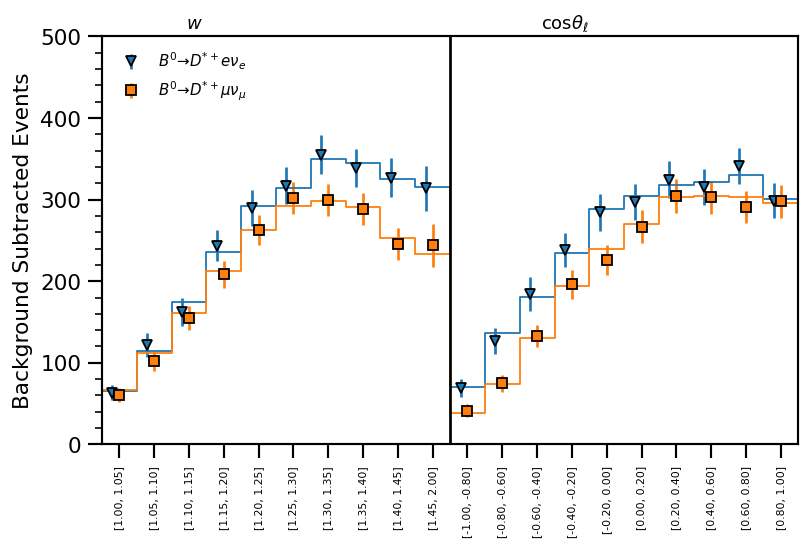

In [41]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for i, channel in enumerate([15, 16]):
    
    result = results[channel]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 20)],
        y=unp.nominal_values(result),
        yerr=unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
        
    )
    
    histogram = full_mc_reco_distributions[channel]
    ax.step(range(-1,21), np.array([histogram[0], *histogram, histogram[-1]]), 
            ls="solid", lw=1, where="mid", color=plt.gca().lines[-1].get_color())

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 500)
ax.set_ylabel("Background Subtracted Events")


plt.tight_layout()
plt.savefig(f"{plotoutdir}/bs_spectrum.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/bs_spectrum.png", transparent=True)   
plt.show()
plt.close()

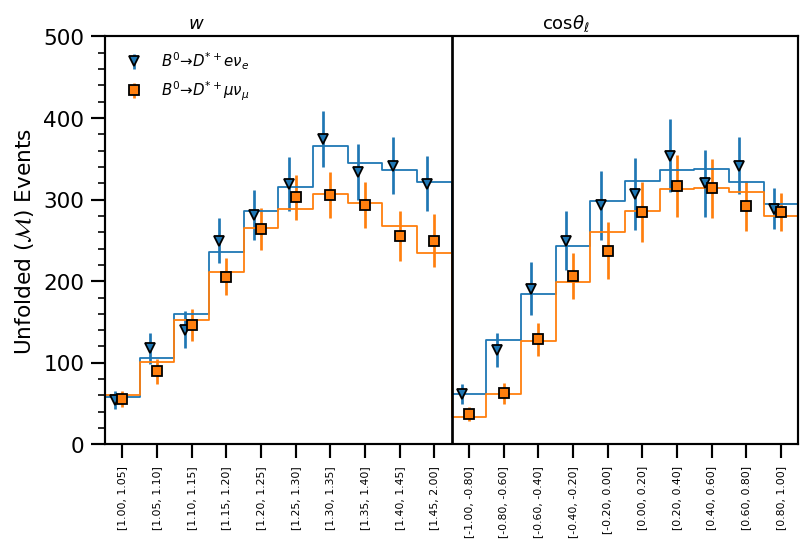

In [42]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for i, channel in enumerate([15, 16]):
    
    inv_m = np.linalg.inv(full_migrations[channel])
    result = inv_m @ results[channel]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 20)],
        y=unp.nominal_values(result),
        yerr=unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
        
    )
    
    histogram = full_mc_distributions[channel]
    ax.step(range(-1,21), np.array([histogram[0], *histogram, histogram[-1]]), 
            ls="solid", lw=1, where="mid", color=plt.gca().lines[-1].get_color())
        

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 500)
ax.set_ylabel(r"Unfolded ($\mathcal{M}$) Events")

plt.tight_layout()
plt.savefig(f"{plotoutdir}/unfolded_m_spectrum.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/unfolded_m_spectrum.png", transparent=True)
plt.show()
plt.close()

In [43]:
def plot_theory(ax, full_theory, bin_widths):
    theory = full_theory[15] * bin_widths["mixed"]
    ax.step(range(-1,21), 1e15*np.array([theory[0], *theory[:20], theory[-1]]), 
            lw=1, ls="-", where="mid", color="black", label="$B^0$ BGL Theory")
    return ax

In [44]:
def get_factor(channel):
    factor = (2*N_BB.nominal_value * BR_GENERIC_MIXED.nominal_value) * tauBzero
    return factor * np.ones(20)

In [45]:
full_theory_bgl

{15: array([2.41605702e-14, 4.10189524e-14, 4.86572993e-14, 5.22436756e-14,
        5.31455727e-14, 5.20494131e-14, 4.93820035e-14, 4.54406339e-14,
        4.04468790e-14, 3.43457819e-14, 4.46712266e-15, 7.01741857e-15,
        9.16272977e-15, 1.09030563e-14, 1.22383981e-14, 1.31687551e-14,
        1.36941275e-14, 1.38145152e-14, 1.35299182e-14, 1.28403364e-14]),
 16: array([2.41605702e-14, 4.10189524e-14, 4.86572993e-14, 5.22436756e-14,
        5.31455727e-14, 5.20494131e-14, 4.93820035e-14, 4.54406339e-14,
        4.04468790e-14, 3.43457819e-14, 4.46712266e-15, 7.01741857e-15,
        9.16272977e-15, 1.09030563e-14, 1.22383981e-14, 1.31687551e-14,
        1.36941275e-14, 1.38145152e-14, 1.35299182e-14, 1.28403364e-14])}

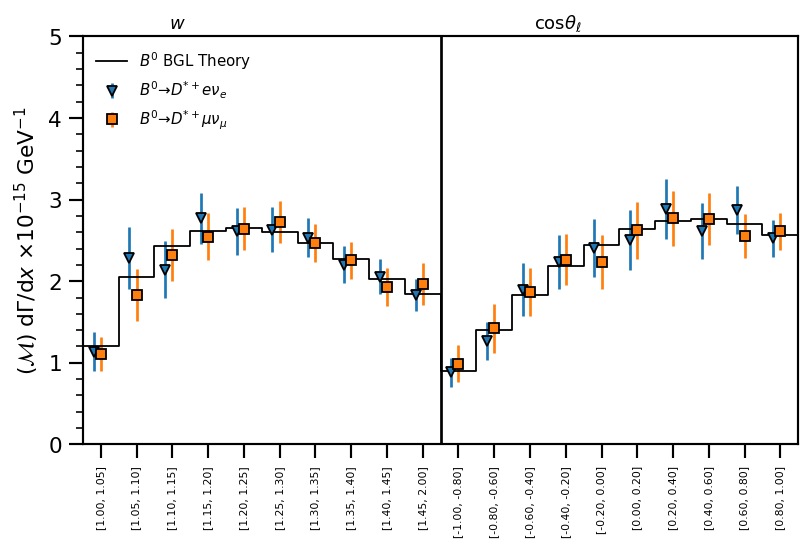

In [46]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for i, channel in enumerate(channels):
    factor = get_factor(channel)
    inv_m = np.linalg.inv(full_migrations[channel])
    result = inv_m @ results[channel]
    
    result = [r / a / f for r, a, f in zip(result, acceptance_corrections[channel], factor)]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 20)],
        y=1e15*unp.nominal_values(result),
        yerr=1e15*unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
        
    )

plot_theory(ax, full_theory_bgl, bin_widths)
make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 5)
ax.set_ylabel(r"($\mathcal{M}$) $\mathrm{d} \Gamma / \mathrm{d}x$ $\times 10^{-15}$ GeV$^{-1}$")

plt.tight_layout()
plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum.png", transparent=True)   
plt.show()
plt.close()

# The Real Deal

Up until now we mainly plotted, but now we want to unfold the full spectrum with correlations across channels.

In [47]:
full_yields = yields['$\nu_\mathrm{sig}$'].values

In [48]:
full_covariance = np.outer(
    yields['$\sigma_\mathrm{tot}$'].values, yields['$\sigma_\mathrm{tot}$'].values
) * pd.read_pickle(os.path.join(f"output/Fitting/{data_type}", f"correlation_full.pkl"))

In [49]:
fit_yields = np.array(correlated_values(full_yields, full_covariance))

In [50]:
inv_m = scipy.linalg.block_diag(*[np.linalg.inv(full_migrations[channel]) for channel in channels])
acceptance_correction = np.array([acceptance_corrections[channel] for channel in channels]).flatten()
factor = np.array([get_factor(channel) for channel in channels]).flatten()
bw = bin_widths["mixed"]

unfolded = inv_m @ fit_yields
corrected =  np.array([r / a / f for r, a, f in zip(unfolded, acceptance_correction, factor)])

In [51]:
np.save(os.path.join(plotoutdir, f"minv_central_values_full.npy"), unp.nominal_values(corrected))

In [52]:
np.save(os.path.join(plotoutdir, f"minv_covariance_full.npy"), uncertainties.covariance_matrix(corrected))

In [53]:
corrected

array([1.1353579062605709e-15+/-2.364329128508161e-16,
       2.2873844033515983e-15+/-3.8369673761373865e-16,
       2.1376711909022846e-15+/-3.506495162376018e-16,
       2.7697437844434208e-15+/-3.265932115499582e-16,
       2.6107154588094894e-15+/-3.053548260990045e-16,
       2.630232658793549e-15+/-2.7874543476020633e-16,
       2.5311687477590417e-15+/-2.630070048152438e-16,
       2.2022734366436323e-15+/-2.4058165431467507e-16,
       2.0540543385576747e-15+/-2.308257709933259e-16,
       1.8255224809268513e-15+/-2.1451280800240995e-16,
       8.836474757353765e-16+/-1.8415490139301503e-16,
       1.2623968433797992e-15+/-2.351649658903415e-16,
       1.8972059394939704e-15+/-3.523673349735656e-16,
       2.234161047837639e-15+/-3.323416693539688e-16,
       2.4036653303302163e-15+/-3.5989287152480087e-16,
       2.5057440964614536e-15+/-3.8438688134087405e-16,
       2.8830977673758237e-15+/-3.9418090576401047e-16,
       2.614087811469285e-15+/-3.5468514779970023e-16,
     